# Compositionality and rarefaction
Amplicon data is relative, AKA compositional. The number of reads for a given taxa in a given sample is in itself arbitrary and can only be interpreted relative to the rest of the taxa in the sample. Unless you have some quantitative estimate on microbial cells for your samples, for example by qPCR, flow cytometry, or an added reference culture in each sample, amplicon data should be intepreted as relative data.

The total number of sequencing reads associated with a sample (read depth, AKA library size) is not associated with the number of cells in the sample. 

Varying read depth in different samples gives rise to two separate problems:
### 1) Abundance estimation
Let's assume 200 reads are assigned to taxa A in sample 1 and 200 reads are assigned to taxa A in sample 2. Taxa A is not necessarily equally abundant in these two samples, unless the read depth is similar in the two samples.

### 2) Detection threshold
We will almost never detect all taxa in a given sample; if they are too rare they will go undetected. Samples with higher read depth will be more likely to include the rare taxa. Therefore, especially if we are interested in the presence/absence of certain taxa, varying read depth across samples can have a large impact.

## Rarefaction curves
A rarefaction curve is a way to estimate how much of the diversity in a sample you have captured. The idea is the following: Take random subsamples of reads from your sample and calculate the diversity in this subsample, while you increase the number of reads you subsample the diversity increases, and if it at some point reaches a platau (before you run out of reads) we can to some extend assume that the diversity in the sample is covered.

**Let's try it in R:**

In [1]:
# Load phyloseq object and packages
library(phyloseq)
library(ggplot2)
library(MicEco)
load("../data/physeq.RData")

We use a function from the MicEco package to calculate the curves

In [ ]:
rc_data <- rcurve(phy, subsamp = seq(from = 1000, to = 100000, by = 1000))

In this plot below, each sample is a line. We see that most samples seem to reach a platau, however, some are still rising until the end. The lines end at different number of reads due to their varying read depth

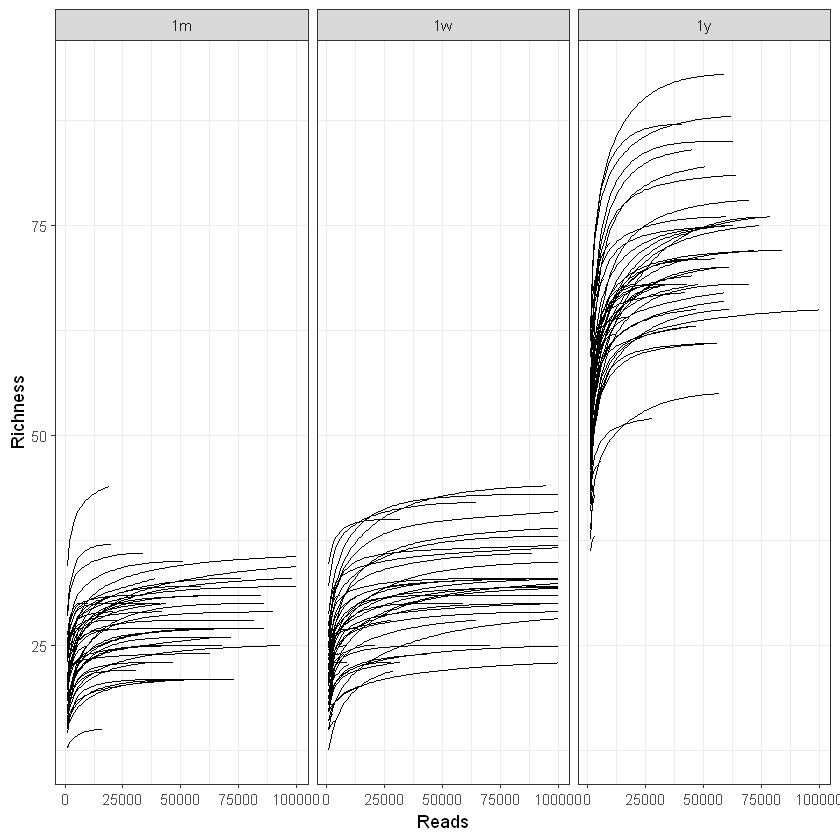

In [3]:
ggplot(rc_data, aes(Reads, Richness, group = Sample)) +
    theme_bw() +
    geom_line() +
    facet_grid(~Time)

## How to solve problem of varying read depth
Varying read depth has to be accounted for in most studies. Below are some methods to reduce/remove the bias created by the read depth. These methods will not make the data non-compositional, they will just alleviate the problems introduced by varying read depth. Sequencing data is inherently compositional no matter the normalization or transformation. Sequence data can only be interpreted as absolute abundances if some measurement of microbial cell count is introduced in the analysis.

### For presence/absence analysis (for example alpha diversity)
There are overall two solutions to this problem:
* 1) Rarefy data
* 2) Include read depth in statistical analysis

### For relative abundance analysis (for example beta diversity, differential abundance)
There are overall three solutions to this problem:
* 1) Rarefy data
* 2) Include read depth in statistical analysis
* 3) Compositional normalization

### 1) Rarefy data
Rarefying data is very popular in the literature and is a way to normalize the data. Basically, you choose a common read depth across all samples. All samples that have fewer reads than this threshold are thrown away. For all samples that have more reads than the threshold you randomly subsample the chosen common read depth (as with the rarefaction curve above). Formally, rarefying is a random subsampling without replacement.

**Advantages:** Simple. "Solves" both the presence/absence and relative abundance problems stated above.

**Disadvantages:** Removing valuable data. Relative abundances become less precise. Producing false zeroes: After rarefying some taxa are suddenly not present in a sample anymore, because the reads were removed, even though these taxa were actually detected. [There are strong opponents against rarefying data](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003531) (Disclaimer: Including this author).

**In R:**

In [4]:
phy_r <- rarefy_even_depth(phy, sample.size=10000, rngseed=42)

`set.seed(42)` was used to initialize repeatable random subsampling.

Please record this for your records so others can reproduce.

Try `set.seed(42); .Random.seed` for the full vector

...

20 samples removedbecause they contained fewer reads than `sample.size`.

Up to first five removed samples are: 


S21S28S29S30S46

...

258OTUs were removed because they are no longer 
present in any sample after random subsampling


...



### 2) Include read depth in statistical analysis
With this method you let the statistical analysis correct for the biases which varying read depth creates. For example, for alpha diversity you would include log10(read depth) in your linear model. For differential abundance there are multiple methods which accounts for read depth without discarding data (See for example the link above, or the [notebook on Differential abundance](https://microucph.github.io/amplicon_data_analysis/html/da.html)).

**Advantanges:** Accurate analyses. Estimate effect of read depth on alpha diversity

**Disadvantages:** Can be more tedious. No simple solution for beta diversity

**In R:**
See notebooks on [Alpha diversity](https://microucph.github.io/amplicon_data_analysis/html/alpha.html) and [Differential Abundance analysis](https://microucph.github.io/amplicon_data_analysis/html/da.html)

### 3) Compositional normalization
With this method we normalize the data to remove the compositional biases. Here just two different methods will be covered:

#### 3.1) Total sum scaling (TSS)
Simply divide the read count with the total number of reads for the sample.

**Advantanges:** Simple. Log-transformation after TSS often works well for Differential abundance. Works well prior to common beta diversity calculations, e.g. Bray-Curtis or weighted UniFrac.

**Disadvantages:** Does not solve the problem of heterogeneity of variance (although log-transformation might solves this).

**In R:**

In [5]:
phy_r <- transform_sample_counts(phy, function(x) x/sum(x))

#### 3.2) Centered log-ratio transformation (CLR)
A dedicated compositional transformation, which uses log-ratio to the geometric mean of the total abundance.

**Advantanges:** Normalizes data, such that common statistical analyses tools can be applied.

**Disadvantages:** Does not work well with any zeroes in the dataset, unless pseudocounts are added (change zeroes to an arbitrary small number)

**In R:**

In [6]:
# Multiplicative replacement of zeroes:
# If there is a 0, insert a 1
# All non-zero values are corrected such that log-ratios before and after correction are the same for non-zero ASVs
phy_zc <- transform_sample_counts(phy, function(y) sapply(y, function(x) ifelse(x==0, 1, (1-(sum(y==0)*1)/sum(y))*x)))
                                                          
# CLR transform
phy_clr <- transform_sample_counts(phy_zc, function(x) log(x/exp(mean(log(x)))))